In [17]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import scipy 
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
import time
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.feature_extraction.text import *
from sklearn.feature_selection import *
from sklearn.preprocessing import *
from sklearn.feature_extraction import text
from sklearn.feature_selection import VarianceThreshold



import time

from wordcloud import WordCloud

import dill

In [4]:
start = time.time()
df = pd.read_csv('C://Users//JCCLI//steam_reviews.csv', nrows=3000000) # Every 2000000 rows occupy ~1GB of main memory and it takes ~21 sec to fetch the data
print("time to fetch data=", time.time()-start)
df.head(5)

time to fetch data= 225.61170887947083


,Unnamed: 0,app_id,app_name,review_id,language,review,timestamp_created,timestamp_updated,recommended,votes_helpful,...,steam_purchase,received_for_free,written_during_early_access,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played
0,0,292030,The Witcher 3: Wild Hunt,85185598,schinese,不玩此生遗憾，RPG游戏里的天花板，太吸引人了,1611381629,1611381629,True,0,...,True,False,False,76561199095369542,6,2,1909.0,1448.0,1909.0,1.611343e+09
1,1,292030,The Witcher 3: Wild Hunt,85185250,schinese,拔DIAO无情打桩机--杰洛特!!!,1611381030,1611381030,True,0,...,True,False,False,76561198949504115,30,10,2764.0,2743.0,2674.0,1.611386e+09
2,2,292030,The Witcher 3: Wild Hunt,85185111,schinese,巫师3NB,1611380800,1611380800,True,0,...,True,False,False,76561199090098988,5,1,1061.0,1061.0,1060.0,1.611384e+09
3,3,292030,The Witcher 3: Wild Hunt,85184605,english,"One of the best RPG's of all time, worthy of a...",1611379970,1611379970,True,0,...,True,False,False,76561199054755373,5,3,5587.0,3200.0,5524.0,1.611384e+09
4,4,292030,The Witcher 3: Wild Hunt,85184287,schinese,大作,1611379427,1611379427,True,0,...,True,False,False,76561199028326951,7,4,217.0,42.0,217.0,1.610788e+09


## Exploratory Data Analysis

In [5]:
df = df[df.language == 'english'].drop(columns=['Unnamed: 0','app_id','language','review_id', 'author.steamid'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1318048 entries, 3 to 2999997
Data columns (total 18 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   app_name                        1318048 non-null  object 
 1   review                          1315805 non-null  object 
 2   timestamp_created               1318048 non-null  int64  
 3   timestamp_updated               1318048 non-null  int64  
 4   recommended                     1318048 non-null  bool   
 5   votes_helpful                   1318048 non-null  int64  
 6   votes_funny                     1318048 non-null  int64  
 7   weighted_vote_score             1318048 non-null  float64
 8   comment_count                   1318048 non-null  int64  
 9   steam_purchase                  1318048 non-null  bool   
 10  received_for_free               1318048 non-null  bool   
 11  written_during_early_access     1318048 non-null  bool   
 12  

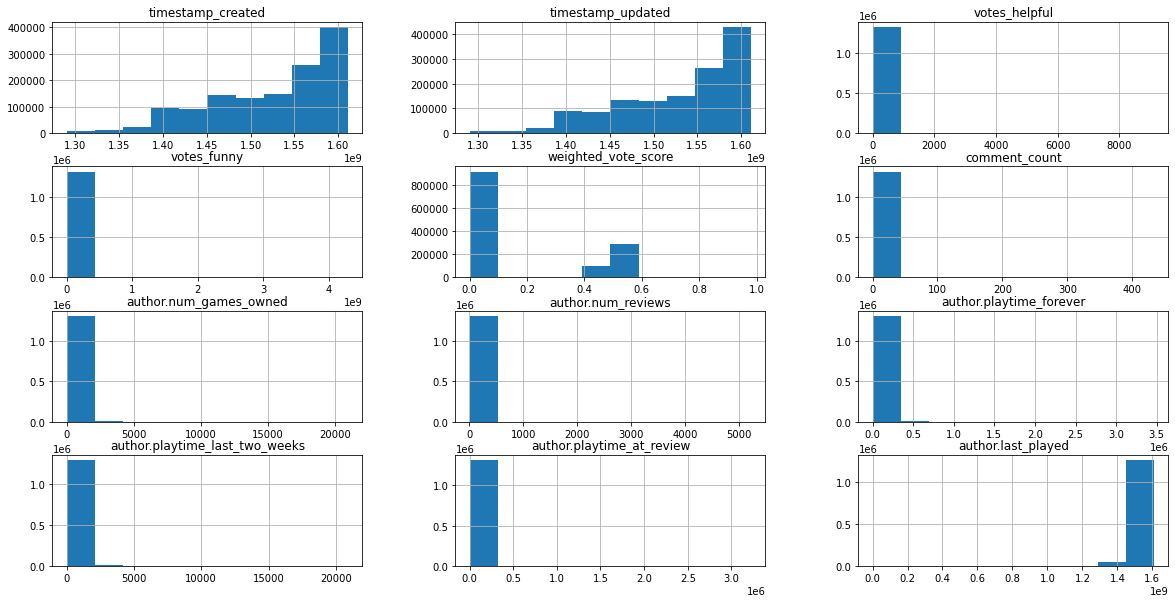

In [7]:
df.hist(figsize=(20,10))
plt.show()

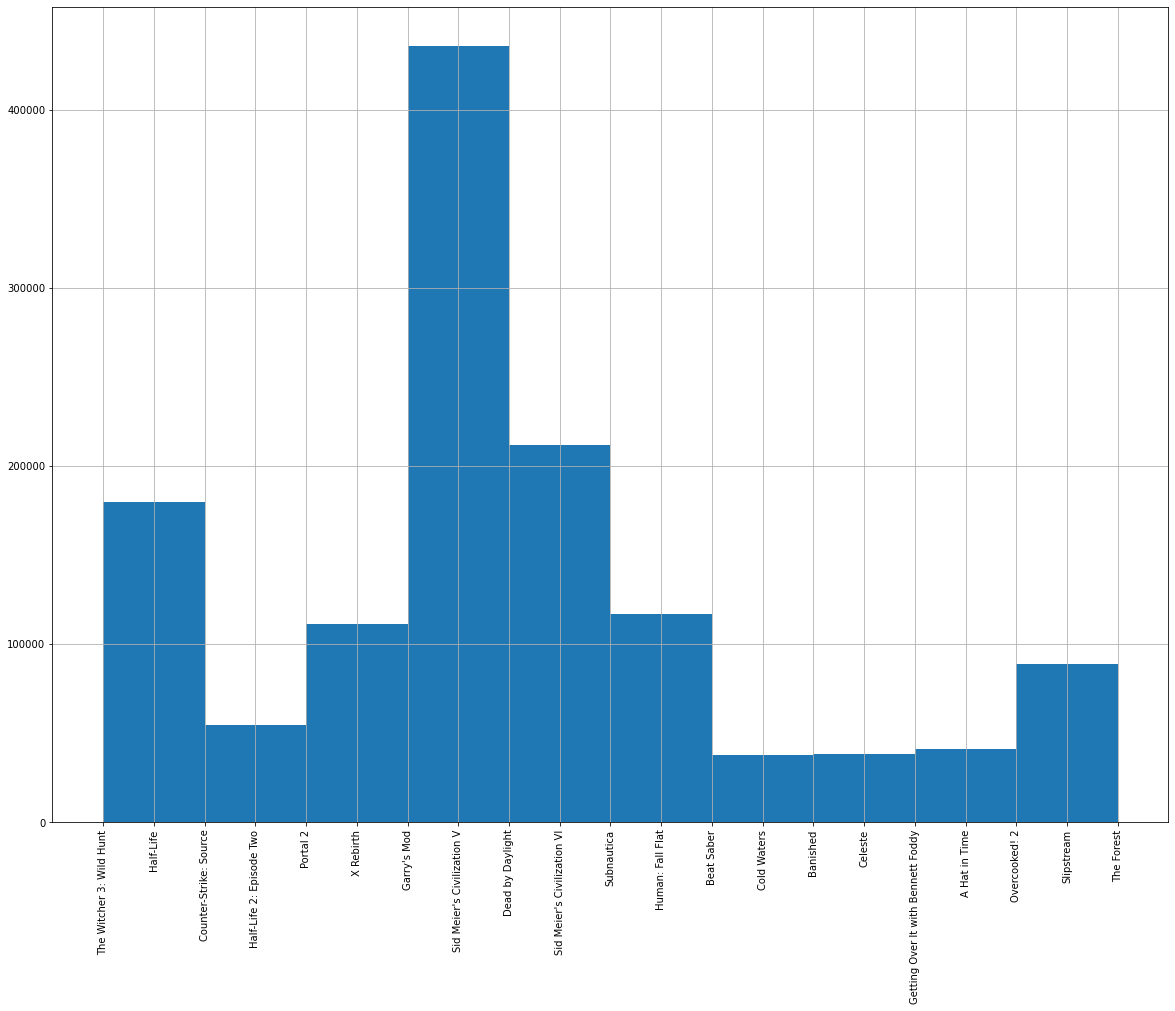

In [10]:
df["app_name"].hist(figsize=(20,15))
plt.xticks(rotation = 90)
plt.show()

## Raw data clusters

In [18]:
vectorizer = TfidfVectorizer(stop_words='english')

vectorized_text = vectorizer.fit_transform(df['review'].fillna(' ').values)

In [19]:
app_name_oe = pd.get_dummies(df['app_name'], prefix='app_name', columns='app_name')
df_oe = pd.concat([df, app_name_oe], axis=1)

In [20]:
def vectorized_dataframe(df, vt):
    non_obj_cols = df[df.select_dtypes(exclude=['object', 'bool']).columns].fillna(0).values
    bool_cols = np.multiply(1, df[df.select_dtypes('bool').columns].values)

    vectorized_data = scipy.sparse.hstack((vt, non_obj_cols, bool_cols))
    return vectorized_data

data = vectorized_dataframe(df_oe, vectorized_text)

In [21]:
def elbow_method(X, K=range(2, 10)):
    inertias = {}
    models = {}

    for k in K:
        m = KMeans(n_clusters=k)
        m.fit(X)
        inertias[k] = m.inertia_
        models[k] = m

    return models, inertias

models, inertias = elbow_method(data)

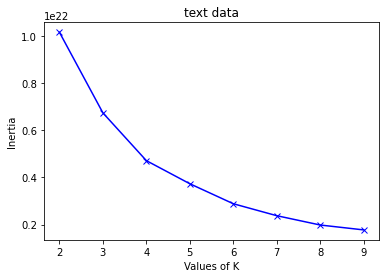

In [22]:
def plot_inertias(inertias, title):
    plt.plot(inertias.keys(), inertias.values(), 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Inertia')
    plt.title(title)
    plt.show()

plot_inertias(inertias, 'text data')

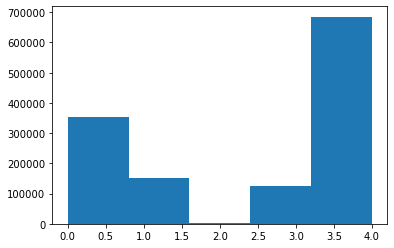

In [23]:
k = 5

def add_labels_to_df(df, k, model):
    df_wlabels = pd.concat(
        [
            df,
            pd.DataFrame(model.labels_, index=df.index, columns=['labels'])
        ], axis=1
    )
    plt.hist(df_wlabels["labels"], bins=k)
    plt.show()
    
    return df_wlabels

df_wlabels = add_labels_to_df(df, k, models[k])

cluster:  0


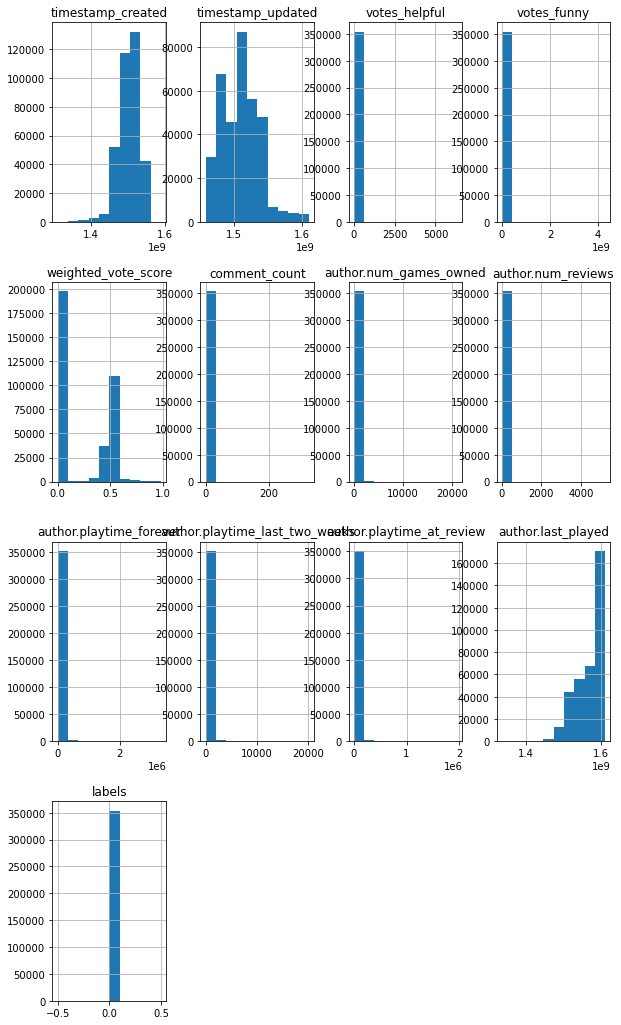

cluster:  1


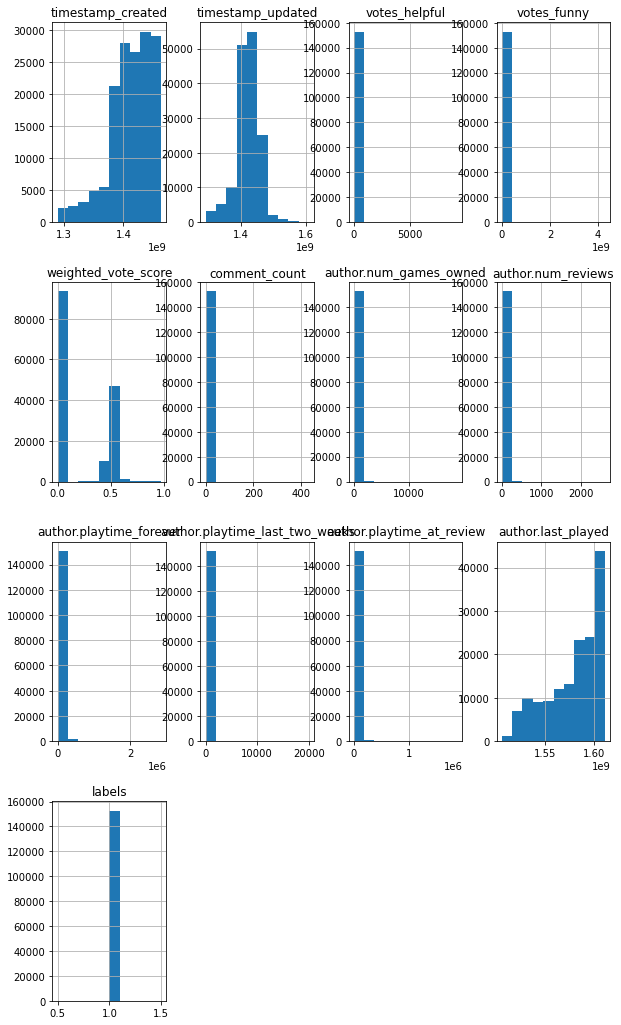

cluster:  2


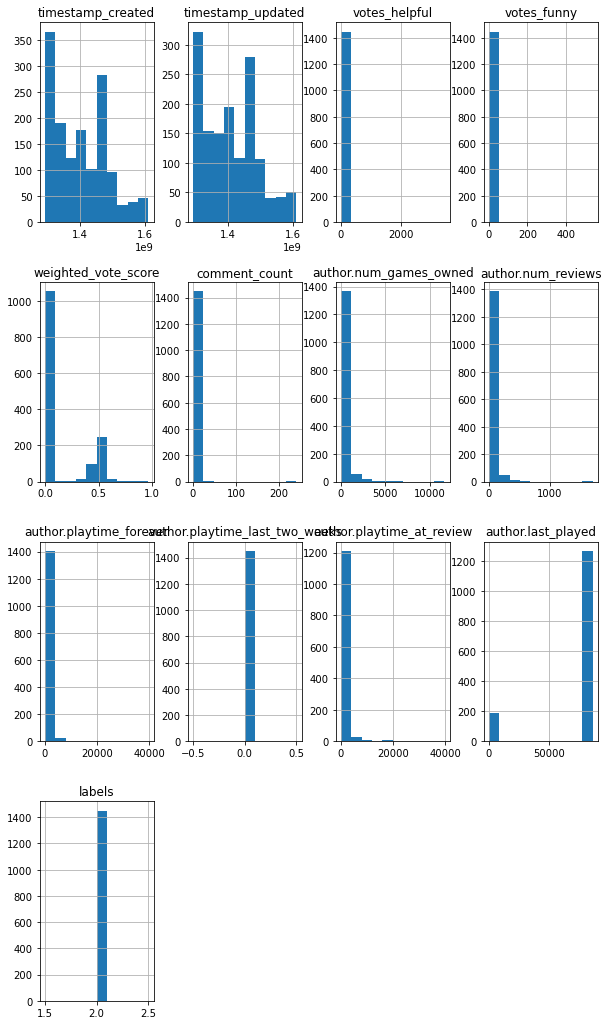

cluster:  3


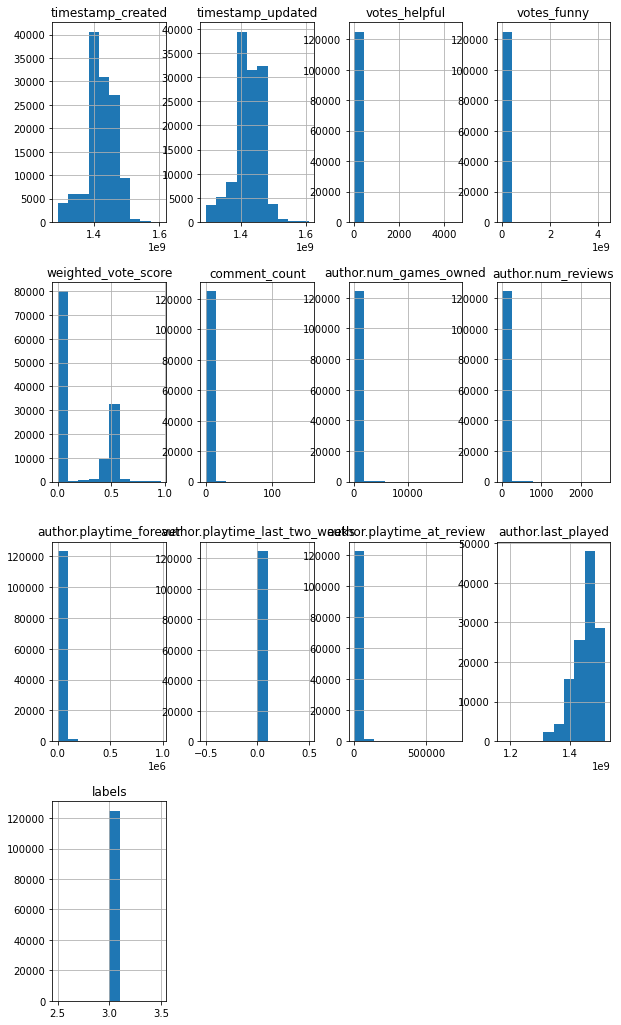

cluster:  4


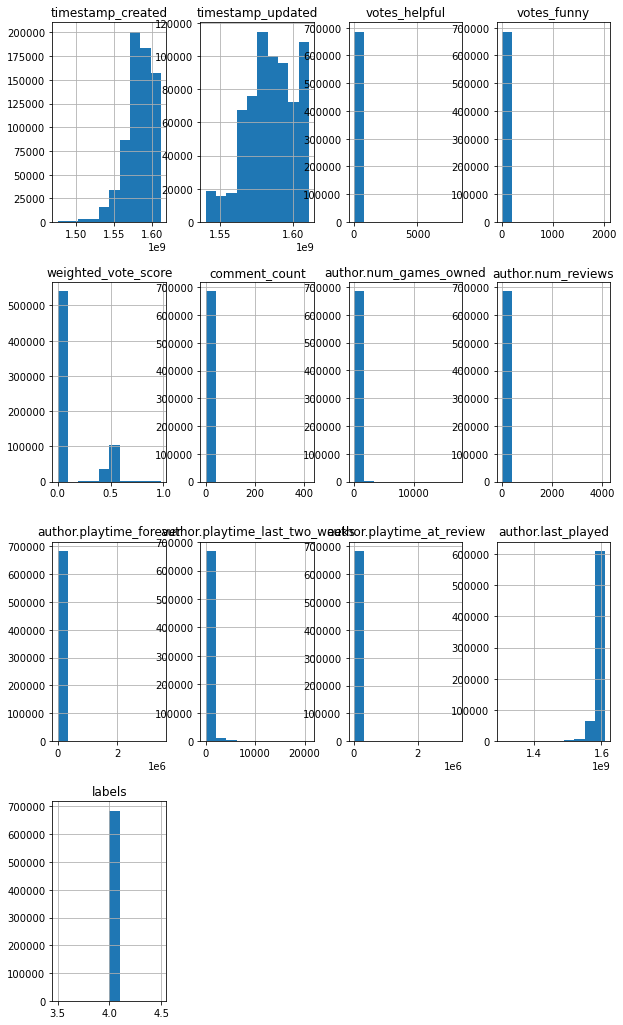

In [25]:
def show_cluster_hist_features(df, k):
    for cluster_idx in range(k):
        print("cluster: ", cluster_idx)
        df[df["labels"] == cluster_idx].hist(figsize=(10,18))
        plt.show()

show_cluster_hist_features(df_wlabels, k)

cluster:  0


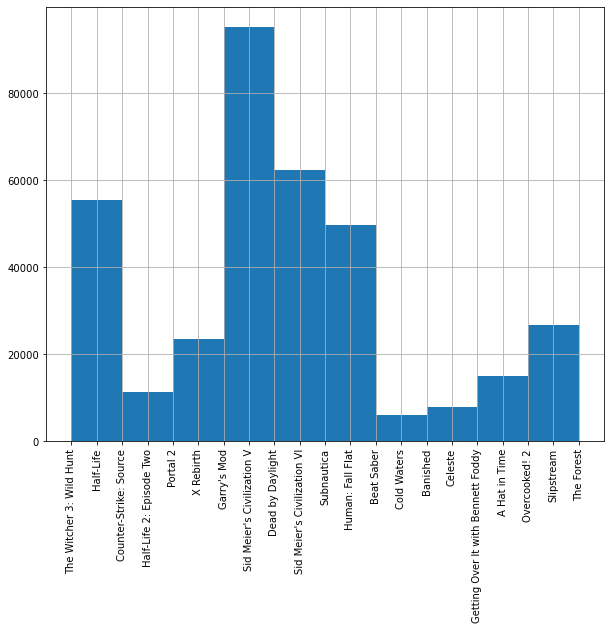

cluster:  1


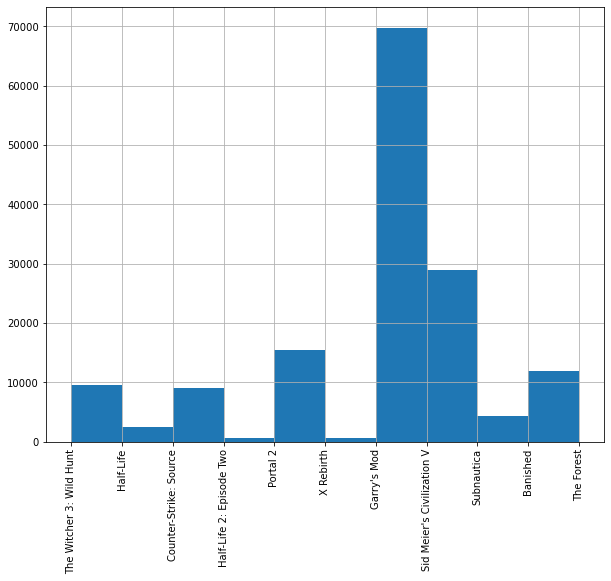

cluster:  2


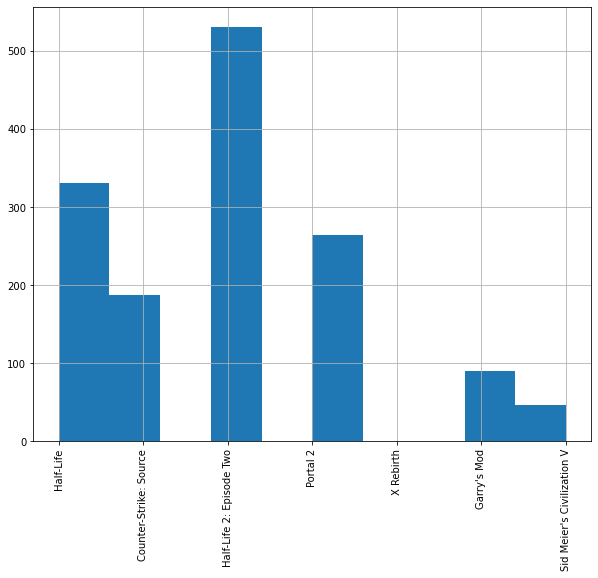

cluster:  3


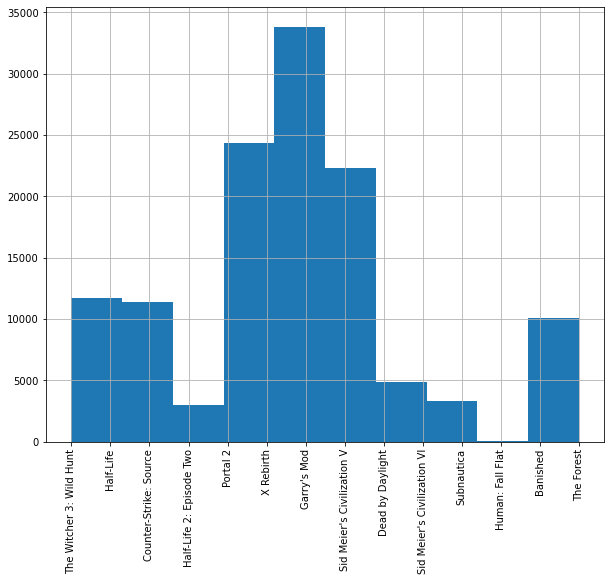

cluster:  4


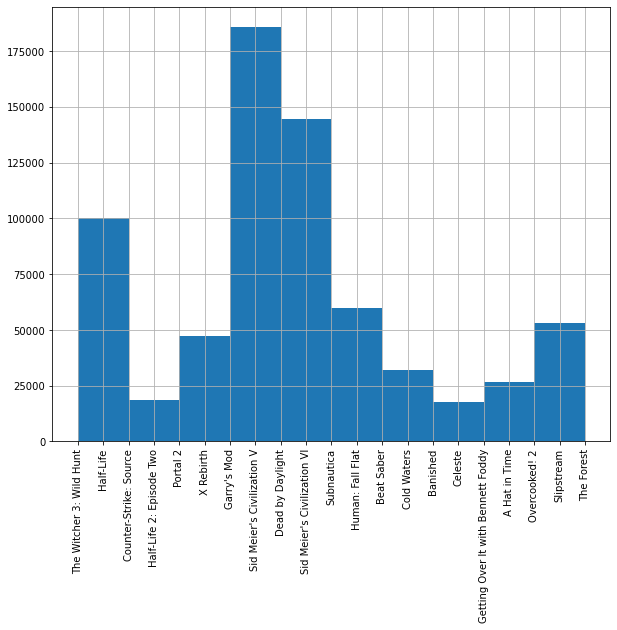

In [26]:
def show_cluster_hist_app_name(df, k):
    for cluster_idx in range(k):
        print("cluster: ", cluster_idx)
        df[df["labels"] == cluster_idx]["app_name"].hist(figsize=(10,8))
        plt.xticks(rotation = 90)
        plt.show()

show_cluster_hist_app_name(df_wlabels, k)

In [27]:
def print_clusters_review(df, k):
    for cluster_idx in range(k):
        print("cluster: ", cluster_idx)
        print(df[df["labels"] == cluster_idx]["review"])

print_clusters_review(df_wlabels, k)

cluster:  0
236983                                         It's awesome.
238806                                  Great fun to be had!
239143                                      damn you're ugly
240404     Is it as good as people say it is?\n\n\nYep, i...
240870     Hands down one of the best game games that I'v...
                                 ...                        
2999833    This is the most boring damn game I've played ...
2999859    I really enjoy this game even though there are...
2999860    After all these years the forest is a game tha...
2999881    Looking forward to the sequel Sons of the Forest.
2999989             havent played in 4 years, seems nice lol
Name: review, Length: 353870, dtype: object
cluster:  1
437019                                Best game of all time.
437049             Just amazing!\n\n\nNothing more to say...
437069     This game was the best game I've played since ...
437109                                       Excellent game!
437143          A

C:\Users\JCCLI\Miniconda_3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


cluster:  0


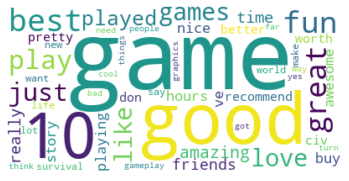

cluster:  1


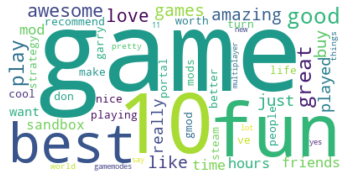

cluster:  2


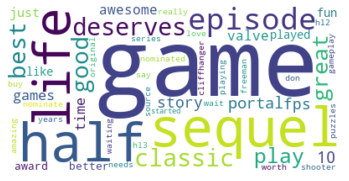

cluster:  3


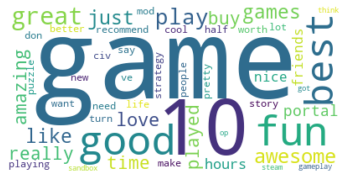

cluster:  4


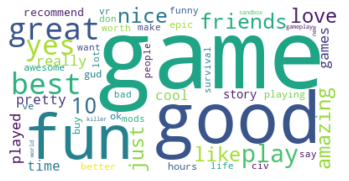

In [30]:
def frequencies_dict(cluster_index, model, k, centroids, terms):    
    frequencies = {}
    sorted_terms = []
    
    term_frequencies = model.cluster_centers_[cluster_index]
    sorted_idx = centroids[cluster_index]
    
    num_feature_not_str = len(df.select_dtypes(exclude='object').columns)
    
    for i in sorted_idx:
        if i < len(terms):
            frequencies[terms[i]] = term_frequencies[i]
            sorted_terms.append(terms[i])
    return frequencies, sorted_terms

def makeImage(frequencies):
    wc = WordCloud(background_color="white", max_words=50)
    # generate word cloud
    wc.generate_from_frequencies(frequencies)

    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
def show_cluster_top_terms(model, vectorizer, k):

    centroids = model.cluster_centers_.argsort()[:, ::-1] ## Indices of largest centroids' entries in descending order
    terms = vectorizer.get_feature_names()

    for cluster_idx in range(k):
        freq, sorted_terms = frequencies_dict(cluster_idx, model, k, centroids, terms)
        print("cluster: ", cluster_idx)
        makeImage(freq)
show_cluster_top_terms(models[k], vectorizer, k)